In [1]:
import importlib
import ds
import augs_copy
import labs

importlib.reload(ds)
importlib.reload(labs)
importlib.reload(augs_copy)

from ds import *
from labs import *
from augs_copy import *

In [2]:
import random
random.seed(707)

# ConvNextV2
- https://huggingface.co/facebook/convnextv2-large-22k-384

In [3]:
model_name = 'facebook/convnextv2-large-22k-384'

# DEF. Dataset and DataModule 

In [4]:
def prepare_example(image_path, processor, transform):
    # load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # load metas
    json_path = Path(image_path).with_suffix(".json")
    meta = load_json(json_path)

    augmented = transform(image=image)
    image = augmented['image']
    
    return processor(image, return_tensors="pt")

In [5]:
class D4Dataset(Dataset):
    def __init__(self, image_paths, targets, processor, transform=None):
        self.targets = targets
        self.processor = processor
        self.transform = transform
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        encoding = prepare_example(image_path, self.processor, self.transform)
        target = int(self.targets[os.path.basename(image_path)])

        return {
            "pixel_values": encoding["pixel_values"].squeeze(0),
            "labels": torch.tensor(target, dtype=torch.long)
        }

In [ ]:
class D4DataModule(LightningDataModule):
    def __init__(
        self,
        train_paths,
        valid_paths,
        trial_paths,
        target_dict,
        processor,
        batch_size=24,
        num_workers=6,
    ):
        super().__init__()
        self.train_paths = train_paths
        self.valid_paths = valid_paths
        self.trial_paths = trial_paths
        self.targets = target_dict
        self.processor = processor
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transforms = Transforms(target_size=384)

    def setup(self, stage=None):
        if stage == "fit":
            self.train_ds = D4Dataset(self.train_paths, 
                                      self.targets, 
                                      self.processor,
                                      self.transforms.make(100))
            self.valid_ds = D4Dataset(self.valid_paths, 
                                      self.targets, 
                                      self.processor,
                                      self.transforms.make(100))
        if stage == "test" or stage is None:
            self.trial_ds = D4Dataset(self.trial_paths, self.targets, self.processor)

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            collate_fn=default_data_collator
        )

    def val_dataloader(self):
        return DataLoader(
            self.valid_ds,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            collate_fn=default_data_collator 
        )

    def test_dataloader(self):
        return DataLoader(
            self.trial_ds,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            collate_fn=default_data_collator 
        )

# INIT. DM

In [7]:
image_paths = grep_files("/root/upstg_CV/data/train", exts=['jpg'])
target_dict = load_csv_targets("/root/upstg_CV/data/train.csv")
label_path = "/root/upstg_CV/data/doc_classes.json"
label2id, id2label = make_doc_class_mapper(label_path)

0it [00:00, ?it/s]

In [8]:
from transformers import AutoImageProcessor
processor = AutoImageProcessor.from_pretrained('facebook/convnextv2-large-22k-384',use_fast=True)

In [9]:
train_images, valid_images, trial_images = split_ds(image_paths,  train_ratio=0.90,  valid_ratio=0.10, trial_ratio=0, seed=8315)

data_module = D4DataModule(
    train_paths=train_images,
    valid_paths=valid_images,
    trial_paths=trial_images,
    target_dict=target_dict,
    processor=processor,
    batch_size=16,
    num_workers=8
)

# DEF) Model

In [10]:
from transformers import ConvNextV2ForImageClassification

In [11]:
class CNN(pl.LightningModule):
    def __init__(self, label2id, id2label):
        super().__init__()
        num_classes = len(label2id)
        self.model = ConvNextV2ForImageClassification.from_pretrained('facebook/convnextv2-large-22k-384', num_labels=num_classes, ignore_mismatched_sizes=True)
        self.model.train()
        self.model.config.label2id = label2id
        self.model.config.id2label = id2label

        metrics = {
            "accuracy": Accuracy(task="multiclass", num_classes=num_classes),
            "per-class-accuracy" : MulticlassAccuracy(num_classes=num_classes, average=None),
            "roc_auc": AUROC(task="multiclass", num_classes=num_classes),
            "precision": Precision(task="multiclass", num_classes=num_classes, average="macro"),
            "recall": Recall(task="multiclass", num_classes=num_classes, average="macro"),
            "F1": F1Score(task="multiclass", num_classes=num_classes, average="macro"),
        }

        self.train_metrics = MetricCollection(metrics, prefix="train_")
        self.valid_metrics = MetricCollection(metrics, prefix="valid_")

    def forward(self, pixel_values, labels=None):
        return self.model(pixel_values=pixel_values, labels=labels)

    def feed(self, batch):
        return self(batch["pixel_values"], batch["labels"])
        
    def training_step(self, batch, batch_idx):
        labels = batch["labels"]
        outputs = self.feed(batch)
    
        self.train_metrics.update(outputs.logits, labels)
        
        self.log("train_loss", outputs.loss)
        for name, metric in self.train_metrics.items():
            if name == 'train_per-class-accuracy':
                continue
            self.log(name, metric.compute(), prog_bar=True)

        # lr 기록
        optimizer = self.optimizers().optimizer
        current_lr = optimizer.param_groups[0]['lr']
        self.log('lr', current_lr)
        
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        labels = batch["labels"]
        outputs = self.feed(batch)

        self.valid_metrics.update(outputs.logits, labels)
        
        self.log("valid_loss", outputs.loss)
        for name, metric in self.valid_metrics.items():
            if name == 'valid_per-class-accuracy':
                continue
            self.log(name, metric.compute(), prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-5, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=3)

        # 1. 지연 단계: total_iters 스텝 동안 초기 학습률 유지
        scheduler_delay = ConstantLR(optimizer, factor=1.0, total_iters=30)
        
        # 2. 웜업 단계: 그 다음 total_iters 스텝 동안 선형 웜업 수행
        scheduler_warmup = LinearLR(optimizer, start_factor=0.01, total_iters=10)
        
        # 3. 메인 스케줄링 단계 (1+2 스텝 이후): 코사인 어닐링 적용 (T_max: 전체 스텝에서 앞선 두 단계를 제외한 스텝 수)
        total_training_steps = 1000 # 총 학습 스텝 수
        scheduler_main = CosineAnnealingLR(optimizer, T_max=total_training_steps - 40, eta_min=1e-6)
        
        # scheduler_delay -> (30 스텝에서) -> scheduler_warmup -> (40 스텝에서) -> scheduler_main
        final_scheduler = SequentialLR(
            optimizer,
            schedulers=[scheduler_delay, scheduler_warmup, scheduler_main],
            milestones=[40, 50]
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": final_scheduler,
                "interval": "step",
                "monitor": "valid_loss"
            }
        }
        
    def on_train_epoch_start(self):
        self.train_metrics.reset()

    def on_train_epoch_end(self):
        metrics = self.train_metrics.compute()
        for name, value in metrics.items():
            if name == 'train_per-class-accuracy':  # 일단 단일 지표들만 모두 출력
                continue
            self.log(name, value)
        # 아래 모델 id2label말고 한글 레이블로 하면 wandb에서 보기는 더 편함
        per_class_acc = metrics['train_per-class-accuracy'] # 클래스별 지표
        for i, acc in enumerate(per_class_acc):  # 각 지표별로 class_id -> 레이블로 변환하여 로그
            label_name = self.model.config.id2label[i]  
            self.log(f'train_acc_class_{label_name}', acc)


    def on_validation_epoch_start(self):
        self.valid_metrics.reset()
    
    def on_validation_epoch_end(self):
        try:
            metrics = self.valid_metrics.compute()
            for name, value in metrics.items():
                if name == 'valid_per-class-accuracy':  # 일단 단일 지표들만 모두 출력
                    continue
                self.log(name, value)
        except Exception as e:
            print(f"Metric compute error: {e}")
        # 아래 모델 id2label말고 한글 레이블로 하면 wandb에서 보기는 더 편함
        per_class_acc = metrics['valid_per-class-accuracy'] # 클래스별 지표
        for i, acc in enumerate(per_class_acc):  # 각 지표별로 class_id -> 레이블로 변환하여 로그
            label_name = self.model.config.id2label[i]  
            self.log(f'valid_acc_class_{label_name}', acc)

# Init Dashboard

In [12]:
exp_name = 'exp-convnext-large-384-transforms-aug-ver2-desque'
wandb.init(project='docsy', name=exp_name)
wandb_logger = WandbLogger()

wandb: Currently logged in as: dhtmdxo12345 (dhtmdxo12345-kyonggi-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# RUN. Train

In [13]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torchmetrics import MetricCollection, Accuracy, F1Score, Precision, Recall, AUROC
from torchmetrics.classification import MulticlassAccuracy
from torch.optim.lr_scheduler import ReduceLROnPlateau, ConstantLR, LinearLR, CosineAnnealingLR, CosineAnnealingWarmRestarts, SequentialLR

In [14]:
early_stopping = EarlyStopping(monitor='valid_loss', patience=10, mode='min')
model_checkpoint = ModelCheckpoint(monitor="valid_loss", mode="min", save_top_k=2)

trainer = pl.Trainer(
    accelerator="gpu",
    precision="16-mixed",
    # make suit 100개라 200개로 함 100으로 해도 됨
    # size의 384 384라 시간이 조금 더 걸림 
    max_epochs=150,
    logger=wandb_logger,
    reload_dataloaders_every_n_epochs=1, 
    callbacks=[model_checkpoint]
    #callbacks=[model_checkpoint, early_stopping]
)

model = CNN(label2id, id2label)
trainer.fit(model, datamodule=data_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Some weights of ConvNextV2ForImageClassification were not initialized from the model checkpoint at facebook/convnextv2-large-22k-384 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([17]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1536]) in the checkpoint and torch.Size([17, 1536]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/tor

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/data/ephemeral/home/.pyenv/versions/py12/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

/data/ephemeral/home/.pyenv/versions/py12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


In [15]:
trainer.save_checkpoint(f"./{exp_name}-last_epoch.ckpt")

In [16]:
wandb.finish()

epoch,▁▁▁▁▁▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
lr,▇▆▁▂▂▂▄██▇▄▃▁▁▅█▇▆▄▂▁▂██▇▆▇█▆▅▂▁▁▄▃▁▁▁▇█
train_F1,▅▁▅▁██▇██▂▇▁▇██▇▂▁▇▂█▂███▇▃▂█▂█▂█▂██▂█▂▁
train_acc_class_account_number,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc_class_application_for_payment_of_pregnancy_medical_expenses,▁███████████████████████████████████████
train_acc_class_car_dashboard,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc_class_confirmation_of_admission_and_discharge,▆▆▁▃▆█▆▄▂▂▃▂▂▃▄▆▄▆▇▆▇▄▆▄▇▆▆▆▃▆▆▆▆▃▇▆▃▃▃▇
train_acc_class_diagnosis,▅▅▅▅▅█▅▅▅▅█▅▁▅█▅▅▅▅▅▅▅▅▅▅▅▅▅▁▅▅▅▅▅▅▅▅▅▅█
train_acc_class_driver_lisence,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc_class_medical_bill_receipts,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc_class_medical_outpatient_certificate,▁▄▇▅▅▅▅▇▅▅▇█▅▄▂▅▅▄▅▄▄▂▂▄▄▇▄▇▇▅▅▁▇▂▁▇▇▅▄▄


---

In [17]:
test_img_paths = grep_files("/root/upstg_CV/deskewed-test", exts=['jpg'])

0it [00:00, ?it/s]

In [18]:
def make_proba_map_conv(image_paths, model, class_names=None):
    # 17개 클래스에 맞게 수정
    ids = list(range(17))  # [0, 1, 2, ..., 16]
    
    # 클래스 이름이 제공되지 않으면 기본값 사용
    if class_names is None:
        # 주의: 이 순서가 모델 학습 시 사용한 순서와 일치해야 합니다!
        class_names = [
            "계좌번호",
            "임신/출산 신청서", 
            "자동차 계기판",
            "입/퇴원 확인서",
            "진단서",
            "운전면허증",
            "진료/의료비 영수증",
            "외래/진료/통원/치료 확인서",
            "주민등록증",
            "여권",
            "(진료비/약제비) 납입 확인서",
            "약국/영수증",
            "처방전",
            "이력서",
            "소견서",
            "자동차 등록증",
            "자동차 번호판"
        ]
    
    labels = class_names
    
    model.eval()
    model = model.to('cuda') 
    rows = []

    # ✅ 추론 루프 - 확률 분포 계산
    for path in tqdm(image_paths):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        inputs = processor(img, return_tensors="pt")['pixel_values'].cuda()

        #inputs = {k: v.cuda() for k, v in inputs.items()}



        # 추론 - 확률 분포 계산
        with torch.no_grad():
            outputs = model(inputs) 
            logits = outputs.logits
            
            # 소프트맥스를 적용하여 확률 분포 계산
            probs = F.softmax(logits, dim=1)
            probs_np = probs.cpu().numpy().squeeze()  # (num_classes,)
            
            # 가장 높은 확률의 클래스 찾기
            pred_class = torch.argmax(logits, dim=1).item()
        
        # 확률을 소수점 2자리로 반올림
        probs_rounded = [float(f"{p:.2f}") for p in probs_np]
        
        # 예측 결과 생성
        guess = f"{labels[pred_class]} [{ids[pred_class]}]"
        
        # 결과 딕셔너리 생성
        item = {
            'code': os.path.basename(path),
            'guess': guess
        }
        
        # 각 클래스별 확률 추가
        for j in range(len(ids)):
            label = f"{labels[j]} [{ids[j]}]"
            item[label] = probs_rounded[j]
        
        rows.append(item)
    
    # 파일명 기준으로 정렬
    rows = sorted(rows, key=lambda x: x['code'])
    return rows




In [19]:
def save_results_to_csv(results, filename):
    """
    결과를 CSV 파일로 저장하는 함수
    
    Args:
        results: make_proba_map_layoutlmv3의 결과 (딕셔너리 리스트)
        filename: 저장할 파일명
    """
    import pandas as pd
    
    # 딕셔너리 리스트를 DataFrame으로 변환
    df = pd.DataFrame(results)
    
    # CSV로 저장
    df.to_csv(filename, index=False, encoding='utf-8-sig')  # 한글 지원을 위해 utf-8-sig 사용
    print(f"결과가 {filename}에 저장되었습니다.")
    
    return df

In [20]:
import torch.nn.functional as F
#ckpt_path = "/root/upstg_CV/chy/llv3-aug/exp-llv3-aug-ost-test4-last_epoch.ckpt"

# 1. 추론 실행
results = make_proba_map_conv(
    test_img_paths, 
    model
)

# 2. CSV 저장
df = save_results_to_csv(results, "[ost]convnext-proba-map-desque-argver2-test.csv")

# 3. 결과 확인
print(f"총 {len(df)}개 이미지 처리 완료")
print(df.head())

  0%|          | 0/3140 [00:00<?, ?it/s]

결과가 [ost]convnext-proba-map-desque-argver2-test.csv에 저장되었습니다.
총 3140개 이미지 처리 완료
                   code        guess  계좌번호 [0]  임신/출산 신청서 [1]  자동차 계기판 [2]  \
0  0008fdb22ddce0ce.jpg  자동차 계기판 [2]       0.0            0.0          1.0   
1  00091bffdffd83de.jpg     처방전 [12]       0.0            0.0          0.0   
2  00396fbc1f6cc21d.jpg    운전면허증 [5]       0.0            0.0          0.0   
3  00471f8038d9c4b6.jpg     처방전 [12]       0.0            0.0          0.0   
4  00901f504008d884.jpg  자동차 계기판 [2]       0.0            0.0          1.0   

   입/퇴원 확인서 [3]  진단서 [4]  운전면허증 [5]  진료/의료비 영수증 [6]  외래/진료/통원/치료 확인서 [7]  \
0           0.0      0.0        0.0             0.0                  0.0   
1           0.0      0.0        0.0             0.0                  0.0   
2           0.0      0.0        1.0             0.0                  0.0   
3           0.0      0.0        0.0             0.0                  0.0   
4           0.0      0.0        0.0             0.0                  0.

In [21]:
model.eval()
model = model.to('cuda') 

In [22]:
preds = []
for p in tqdm(test_img_paths):
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    inputs = processor(img, return_tensors="pt")['pixel_values'].cuda()

    with torch.no_grad():
        outputs = model(inputs)  # labels 없이 호출해도 됨
        logits = outputs.logits
        pred_class = torch.argmax(logits, dim=1).item()

    preds.append((p, pred_class))

  0%|          | 0/3140 [00:00<?, ?it/s]

In [23]:
import pandas as pd
def write_csv_value(csv_path, preds):
    df = pd.read_csv(csv_path)
    for i, item in enumerate(preds):
        filename = os.path.basename(item[0])
        df.loc[df['ID'] == filename, 'target'] = item[1]
        
    df.to_csv(csv_path, index=False, encoding='utf-8')

In [24]:
write_csv_value("/root/upstg_CV/data/sample_submission_cnn.csv", preds)

In [37]:
submission = pd.read_csv("/root/upstg_CV/data/sample_submission.csv")

for i, item in enumerate(preds):
    filename = os.path.basename(item[0])
    submission.loc[submission['ID'] == filename, 'target'] = item[1]

In [38]:
submission.head()

,ID,target
0,0008fdb22ddce0ce.jpg,0
1,00091bffdffd83de.jpg,0
2,00396fbc1f6cc21d.jpg,0
3,00471f8038d9c4b6.jpg,0
4,00901f504008d884.jpg,0


# 체크포인트 로드

In [44]:
ckpt_path = "/root/upstg_CV/chy/cnn/lightning_logs/gvuq701t/checkpoints/epoch=135-step=12104.ckpt"
model = CNN.load_from_checkpoint(ckpt_path, id2label=id2label, label2id=label2id)

Some weights of ConvNextV2ForImageClassification were not initialized from the model checkpoint at facebook/convnextv2-large-22k-384 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([17]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1536]) in the checkpoint and torch.Size([17, 1536]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
model.eval()
model = model.to('cuda') 

In [47]:
img = cv2.imread(test_img_paths[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = processor(img, return_tensors="pt")['pixel_values']
img = img.cuda()
outs = model(img)

In [48]:
label_trans = {
    "account_number":"계좌번호",
    "application_for_payment_of_pregnancy_medical_expenses": "임신/출산 신청서",
    "car_dashboard": "자동차 계기판",
    "confirmation_of_admission_and_discharge": "입퇴원 확인서",
    "diagnosis": "진단서",
    "driver_lisence": "운전면허증",
    "medical_bill_receipts": "진료/의료비 영수증",
    "medical_outpatient_certificate": "(외래)진료(통원/치료) 확인서",
    "national_id_card": "주민등록증",
    "passport": "여권",
    "payment_confirmation": "(진료비/약제비) 납입 확인서",
    "pharmaceutical_receipt": "약국/영수증",
    "prescription": "처방전",
    "resume": "이력서",
    "statement_of_opinion": "소견서",
    "vehicle_registration_certificate": "자동차 등록증",
    "vehicle_registration_plate": "자동차"
}

# 체크포인트 저장하고 로드하고 로짓으로 TOP3 혹은 전체 표 작성

In [49]:
class_names = [label_trans[k] for k in label2id.keys()]
logits_to_prob_table(outs.logits, class_names=class_names)

,정답,계좌번호,임신/출산 신청서,자동차 계기판,입퇴원 확인서,진단서,운전면허증,진료/의료비 영수증,(외래)진료(통원/치료) 확인서,주민등록증,여권,(진료비/약제비) 납입 확인서,약국/영수증,처방전,이력서,소견서,자동차 등록증,자동차
0,,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9999,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


shape HWC:(611, 428, 3)


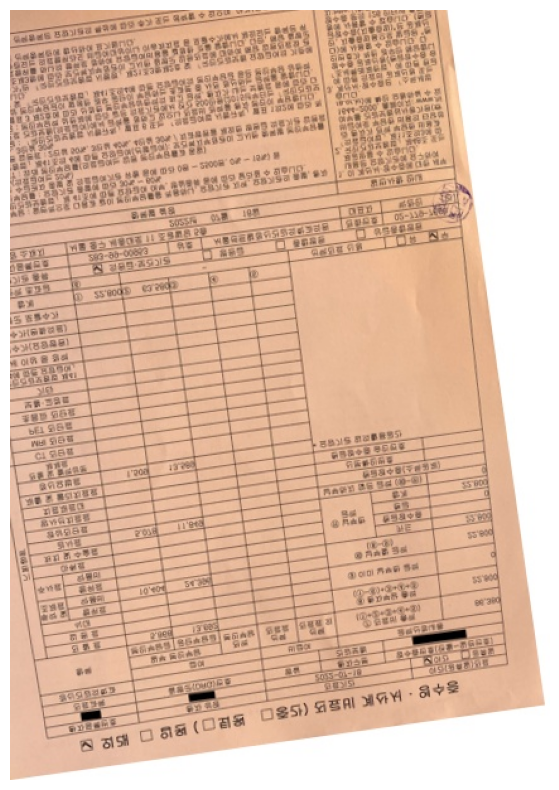

In [50]:
show_img(test_img_paths[0])